# LGBM Model
* RNN was far too slow and hence infeasible given the time limit I am constrained within
* So going to use an LGBM

# Misc / setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import datetime
from IPython.display import display
from pprint import pprint
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn import preprocessing
import seaborn as sns

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

In [2]:
import random
SEED = 137
random.seed(SEED)

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# loading the data

In [4]:
df_train = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all.pkl")
display(df_train)
df_preds = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all_preds.pkl")
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,semi_detached,terraced,energy n-7,energy n-6,energy n-5,energy n-4,energy n-3,energy n-2,energy n-1,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,21.999000,26.232000,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,26.232000,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000,19.204000,17.397000


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,semi_detached,terraced,energy n-7,energy n-6,energy n-5,energy n-4,energy n-3,energy n-2,energy n-1,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# formatting the df's

In [5]:
#replacing nans with 0 so we can aggregate up the OOF predictions
df_preds["meter_reading"] = df_preds["meter_reading"].fillna(0) 
#dropping the "energy n-k" columns as they are needed for 3D RNN input not 2D LGBM input
df_preds = df_preds.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)
df_train = df_train.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)

display(df_train)
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the ID's
* One hot / binary encoding can actually worsen performance of DT based algorithms
* and LGBM supports categorical values; so no need to use the binary encoded meter_id which we planned for the RNN
* Hence I will also now encode the ID ordinally and experiment with both to see which gives the best performing results

In [6]:
#removing the binary encoded ID's as LGBM supports categorical values hence we can just use ordinal encoded ID's for better performance
#commented out for random search as will experiment with using both
# binary_encoded_cols=[]
# for i in range(13):
#     binary_encoded_cols.append(f"meter_id_{i}")
# df_train=df_train.drop(binary_encoded_cols,axis=1)
# df_preds=df_preds.drop(binary_encoded_cols,axis=1)

In [7]:
#ordinally encoding id's
le = preprocessing.LabelEncoder()
le.fit(df_train["meter_id"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(1, "meter_id_ord", le.transform(df_train["meter_id"]))
df_preds.insert(1, "meter_id_ord", le.transform(df_preds["meter_id"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,425,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,542,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,585,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,688,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,793,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the dwelling_type
* same reasons for replacing the binary encoded meter_id with ordinal encoding; going to replace one hot encodede dwelling type with ordinal encoding

In [8]:
#removing the binary encoded ID's as LGBM supports categorical values hence we can just use ordinal encoded ID's for better performance
# not dropping the orginal random search will experiment with ordinal and onehot
# onehot_encoded_cols = ["detached","flat","terraced","semi_detached"]
# df_train=df_train.drop(onehot_encoded_cols,axis=1)
# df_preds=df_preds.drop(onehot_encoded_cols,axis=1)

In [9]:
#ordinally encoding dwelling_type
le = preprocessing.LabelEncoder()
le.fit(df_train["dwelling_type"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(27, "dwelling_type_ord", le.transform(df_train["dwelling_type"]))
df_preds.insert(27, "dwelling_type_ord", le.transform(df_preds["dwelling_type"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,425,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,542,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,585,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,688,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,793,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0


# SKF-CV for training the LGBM
* Using skf on df_train by meter_id with 3 folds
    * Meaning for each iteration we use 2/3 of each meters data for training and 1/3 of each meters data for validating
* using out of fold predictions, making predictions on each fold and aggregating them together for the final prediction

* evaluates the model via OOF predictions made on the held out set on each fold
* this score is returned and along with the 3 models
* random search will then be used to find the LGBM hyper param config with the best val score and this will then be used to make predictions using the model which has the best validation score

In [10]:
import warnings
warnings.filterwarnings("ignore")

#function for running the cross fold
    #args:
        #disp_fold_info = True if we want to print info for each fold
        #disp_end_info = True if we want to display evaluation info at the end
        #SEED = random seed used for fair repeatability
        #num_folds = number of folds in skf (pretty certain going to keep this at 3 )
        #df_train = training dataframe
        #y_col = the name of the label we want to predict (meter_reading)
        #X_cols = the name of the feature columns we are using
        #X_cat = the name of these features which are categorical
        #params = hyper params for the LGBM model
    #returns:
        #time_of_execution = how long it took to train the model on all folds; will be used as a point of comparison
        #valid_score = MAE calculated using the Out-of-Fold Predictions on the df_train, used for hyper-param tuning
        #lgbm_models = array of the different lgbm_models
        
def run_lgbm_skf_cv(disp_fold_info, disp_end_info, SEED, num_folds, df_train, y_col, X_cols, X_cat, params):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = SEED) # defining the SKF algorithm

    lgbm_models = []
    start_time = time.time()
    fold_iter=1
    #running the startified kfold, splitting df_train by meter_id, so we use 2/3 of each meters reading for training
    for train_index, valid_index in skf.split(df_train, df_train["meter_id"]):

        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Fold {fold_iter}{color.END}")
        
        #splitting into the features and labels for the train and valid folds
        X_train, X_valid = df_train.loc[train_index, X_cols], df_train.loc[valid_index, X_cols]
        y_train, y_valid = df_train.loc[train_index, y_col], df_train.loc[valid_index, y_col]
        
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}X_train{color.END}")
            display(X_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_train{color.END}")
            display(y_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}X_valid{color.END}")
            display(X_valid.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_valid{color.END}")
            display(y_valid.head(5))
            
        print(f"{color.CYAN}{color.UNDERLINE}Training the LGBM{color.END}")
        #instantiating a lgbm regressor with our params
        lgbm_model = lgbm.LGBMRegressor(**params)
        #fitting the lgbm model on the 2/3 train and evaluating on the 1/3 valid
        #printing details every 1000 iters + stopping if no improvement made in 250 iters
        lgbm_model.fit(X_train, y_train,
                       eval_set=[(X_valid, y_valid)],
                       categorical_feature=X_cat,
                       verbose=1000,
                       early_stopping_rounds=250)
        
        #saving the OOF prediction for the held out rows (valid rows from df_train) from the lgbm model with the best performing intrinisic parmams 
        oof_valid = lgbm_model.predict(X_valid, num_iteration=lgbm_model.best_iteration_) # making prediction on the held out rows, X_valid
        df_train.loc[valid_index, "oof"] = oof_valid #storing the oof rows 
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}df_train OOF predictions{color.END}")
            display(df_train.loc[valid_index, ["meter_id","oof"]].head(5))
               
        #appending this lgbm
        lgbm_models.append(lgbm_model)
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}lgbm_models size{color.END}: {len(lgbm_models)}")
            
        fold_iter+=1
        
    if(disp_end_info):
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}training set OOF preds vs true{color.END}")
        display(df_train[["meter_id","date","meter_reading","oof"]])
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(LGBM_TOE)))}\n")
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}\n")
    
    #calculating execution time and the MAE on the training set
    time_of_execution = time.time() - start_time
    valid_score=mean_absolute_error(df_train[y_col], df_train["oof"]) 
    
    
    return (time_of_execution, valid_score, lgbm_models)


# Running random search on the LGBM skf-cv function
* going to run random search to find the hyper param config which gav the best MAE on OOF predictions on the train ste in skf-cv
    * originally implemented grid search in an earlier commit but it was incredibly slow due to the exponential growth from the wide range of hyper paramaeters
        * decided to use random search has it has been proven to be more efficient than grid search in research eg in the paper" Random search for hyper-parameter optimization" (James bergstra et al. 2012 Montreal)


In [11]:
y_col = "meter_reading" #we want to predict the meter_reading (this will always be the same)

## Setting the column types and grouping ones together that should be grouped
* Not specifying configurations anymore letting random search pick them itself

In [12]:
#dictionary to hold all groups of columns which could be chosen
#done as if we just pick columns completely random we may get just "meter_id_3" from the binary encoded meter_id's
#wouldn't make any sense without the other respective binary encoded meter_id columns

possible_columns = {}
possible_columns["meter_id_ord"] = ["meter_id_ord"]
possible_columns["meter_id_binary"] = ['meter_id_0', 'meter_id_1', 'meter_id_2',
       'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
       'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12']
possible_columns["day_of_year_cyclic"] = ["day_of_year_sin","day_of_year_cos"]
possible_columns["day_of_week"] = ["day_of_week"]
possible_columns["day_of_month"] = ["day_of_month"]
possible_columns["month_ord"] = ["month_ord"]
possible_columns["month_cyclic"] = ["month_sin","month_cos"]
possible_columns["is_weekend"] = ["is_weekend"]
possible_columns["energy_cluster"] = ["energy_cluster"]
possible_columns["num_bedrooms"] = ["num_bedrooms"]
possible_columns["dwelling_type_ord"] = ["dwelling_type_ord"]
possible_columns["dwelling_type_onehot"] = ['detached', 'flat', 'semi_detached', 'terraced']
pprint(possible_columns)

{'day_of_month': ['day_of_month'],
 'day_of_week': ['day_of_week'],
 'day_of_year_cyclic': ['day_of_year_sin', 'day_of_year_cos'],
 'dwelling_type_onehot': ['detached', 'flat', 'semi_detached', 'terraced'],
 'dwelling_type_ord': ['dwelling_type_ord'],
 'energy_cluster': ['energy_cluster'],
 'is_weekend': ['is_weekend'],
 'meter_id_binary': ['meter_id_0',
                     'meter_id_1',
                     'meter_id_2',
                     'meter_id_3',
                     'meter_id_4',
                     'meter_id_5',
                     'meter_id_6',
                     'meter_id_7',
                     'meter_id_8',
                     'meter_id_9',
                     'meter_id_10',
                     'meter_id_11',
                     'meter_id_12'],
 'meter_id_ord': ['meter_id_ord'],
 'month_cyclic': ['month_sin', 'month_cos'],
 'month_ord': ['month_ord'],
 'num_bedrooms': ['num_bedrooms']}


In [13]:
# setting categorical columns

all_cat = ["meter_id_ord", 'meter_id_0', 'meter_id_1', 'meter_id_2',
           'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
           'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12',
           "day_of_week", "day_of_month", "month_ord", "is_weekend", "energy_cluster",
           "dwelling_type_ord", "detached", "flat", "semi_detached", "terraced"] #all categorical values

# setting categorical columns in the dataframe to be categorical
#X_cat[0] holds all columns (besides clusters but we aren't using that) 
for i in all_cat:
    df_train[i] = df_train[i].astype('category')
    df_preds[i] = df_preds[i].astype('category')

### Defining the model parameters for random search
* sensible different combinations of params for the model

* default values which make sense and the others have place holders as they will be found in random search

In [14]:
#default params (including ones we will override and those we won't)
params = {
    ### won't be tuned ###
    'boosting_type': 'gbdt', #gbdt/rf/dart/goss
    'metric': 'mae', 
    'num_threads': -1, # number of threads to run on for speed (auto)
    'num_iterations': 10000, #defining the models runs
    'seed': SEED, # all runs with same seed for better comparison between different hyper params
    
    
    ### will be tuned (replace these with the best performing) ###
    'learning_rate': 0.99999,
    'num_leaves': 99999, # limit max numer of leaves in a tree
    "max_depth":99999, # limit max depth of the tree to prevent overfitting
    # fraction to be bagged/sampled every k iterations
    'bagging_fraction': 0.99999,
    'bagging_freq' : 99999,
    'feature_fraction': 0.99999, # fraction of features to use at each tree node
    #l1 & l2 regularization to prevent overfitting
    "lambda_l1": 99999,
    "lambda_l2": 99999
}

pprint(params)

{'bagging_fraction': 0.99999,
 'bagging_freq': 99999,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.99999,
 'lambda_l1': 99999,
 'lambda_l2': 99999,
 'learning_rate': 0.99999,
 'max_depth': 99999,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 99999,
 'num_threads': -1,
 'seed': 137}


## Running the random search

In [15]:
num_folds = 3 # 3 fold skf; so we use 2/3 of each meters readings for training at each iteration 
i=0 #just used to print the index of each skf-cv run
all_results = [] # will hold array of all the tuples of results + hyper params

#random search
print(f"{color.BOLD}Running random search hyper parameter optimization{color.END}\n")
start_time = time.time()
#going to test n hyper parameter configurations
n=64
for i in tqdm(range(n)):
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}skf-cv LGBM run {i}{color.END}")
    #### randomly generate the hyper parameters for this model within a sensible range for each ####

    #firstly randomly picking the features we will use
    print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Picking random features{color.END}")
    X_cols = []#this will store the X_cols we use

    #generating probability of accepting each column
    prob_to_beat = random.randrange(30,100)/100 #between 0.3 and 1
    #iterating through each column and randomly decide whether or not to pick it
    for key in possible_columns.keys():
        #randomly generate a decimal for this column group
        this_prob = random.randrange(0,100)/100 #between 0 and 1
        #if this is less than the probability to beat then accept it
        if(this_prob<prob_to_beat):
            print(key,this_prob,"<=",prob_to_beat)
            X_cols+=(possible_columns[key])
    print(X_cols)
    
    this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
    
    #then get LGBM hyper parameters
    this_params = params.copy()
    this_params["learning_rate"] = random.randrange(10,25)/1000 #between 0.01 and 0.025
    this_params["max_depth"] = random.randrange(6,12)
    this_params["num_leaves"] = random.randrange(np.round(2**(this_params["max_depth"])*0.5), np.round(2**(this_params["max_depth"])*0.9)) #picking a random max leaves less than 2^(max_depth) to prevent over fitting (between 50 and 90%)
    this_params["bagging_fraction"] = random.randrange(65,90)/100 #between 0.65 and 0.9
    this_params["bagging_freq"] = random.randrange(5,25)
    this_params["feature_fraction"] = random.randrange(65,90)/100 #between 0.65 and 0.9
    this_params["lambda_l1"] = random.randrange(8,18)
    this_params["lambda_l2"] = random.randrange(4,14)

    #train the model with this hyper param config and store it's results

    pprint(this_params)
    all_results.append((run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params),(X_cols,this_params)))
    print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Random search ran {n} iterations in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

Running random search hyper parameter optimization



  0%|          | 0/64 [00:00<?, ?it/s]

skf-cv LGBM run 0
Picking random features
meter_id_ord 0.23 <= 0.39
day_of_week 0.24 <= 0.39
day_of_month 0.29 <= 0.39
is_weekend 0.01 <= 0.39
['meter_id_ord', 'day_of_week', 'day_of_month', 'is_weekend']
{'bagging_fraction': 0.69,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.81,
 'lambda_l1': 16,
 'lambda_l2': 9,
 'learning_rate': 0.023,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 754,
 'num_threads': -1,
 'seed': 137}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.69, subsample=1.0 will be ignored. Current value: bagging_fraction=0.69
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_l

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 4.88443
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.83, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.83
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.66, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 4.8859
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.0468
[2000]	valid_0's l1: 2.01968
[3000]	valid_0's l1: 2.01072
[4000]	valid_0's l1: 2.00472
[5000]	valid_0's l1: 2.00133
[6000]	valid_0's l1: 1.99958
[7000]	valid_0's l1: 1.99846
Early stopping, best iteration is:
[6872]	valid_0's l1: 1.99823
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.86, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.86
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_f

[4000]	valid_0's l1: 4.53941
[5000]	valid_0's l1: 4.50641
[6000]	valid_0's l1: 4.47373
[7000]	valid_0's l1: 4.44331
[8000]	valid_0's l1: 4.42193
[9000]	valid_0's l1: 4.39998
[10000]	valid_0's l1: 4.38073
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 4.38073




skf-cv LGBM run 7
Picking random features
meter_id_binary 0.5 <= 0.72
day_of_year_cyclic 0.01 <= 0.72
day_of_week 0.6 <= 0.72
month_ord 0.4 <= 0.72
month_cyclic 0.01 <= 0.72
is_weekend 0.56 <= 0.72
energy_cluster 0.07 <= 0.72
dwelling_type_ord 0.24 <= 0.72
dwelling_type_onehot 0.48 <= 0.72
['meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'month_ord', 'month_sin', 'month_cos', 'is_weekend', 'energy_cluster', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
{'bagging_fraction': 0.79,
 'bagging_freq':

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.99974
[2000]	valid_0's l1: 1.96733
[3000]	valid_0's l1: 1.95094
[4000]	valid_0's l1: 1.94036
[5000]	valid_0's l1: 1.93282
[6000]	valid_0's l1: 1.92643
[7000]	valid_0's l1: 1.92096
[8000]	valid_0's l1: 1.91584
[9000]	valid_0's l1: 1.911

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.74, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.84, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[482]	valid_0's l1: 2.83447
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.74, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74
[LightGBM] [Warning] lambda_l1 is set=14, 

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.00434
[2000]	valid_0's l1: 1.97249
[3000]	valid_0's l1: 1.95906
[4000]	valid_0's l1: 1.9501
[5000]	valid_0's l1: 1.94479
[6000]	valid_0's l1: 1.93964
[7000]	valid_0's l1: 1.93617
[8000]	valid_0's l1: 1.93242
[9000]	valid_0's l1: 1.92966
[10000]	valid_0's l1: 1.92674
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.92674
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.77, subsample=1.0 will be ignored. Current value: bagging_fraction=0.77
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.62927
[2000]	valid_0's l1: 2.5681
[3000]	valid_0's l1: 2.54175
[4000]	valid_0's l1: 2.52361
[5000]	valid_0's l1: 2.50868
[6000]	valid_0's l1: 2.49667
[7000]	valid_0's l1: 2.4872
[8000]	valid_0's l1: 2.48089
[9000]	valid_0's l1: 2.47443
[10000]	valid_0's l1: 2.4691
Did not meet early stopping. Best iteration is:
[9998]	valid_0's l1: 2.4691
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.82, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[Lig

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.31204
[2000]	valid_0's l1: 2.13875
[3000]	valid_0's l1: 2.09369
[4000]	valid_0's l1: 2.07167
[5000]	valid_0's l1: 2.05538
[6000]	valid_0's l1: 2.04269
[7000]	valid_0's l1: 2.03318
[8000]	valid_0's l1: 2.02487
[9000]	valid_0's l1: 2.01744
[10000]	valid_0's l1: 2.01057
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.01057
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.87, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.87
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.73, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[8000]	valid_0's l1: 1.91549
[9000]	valid_0's l1: 1.91098
[10000]	valid_0's l1: 1.90614
Did not meet early stopping. Best iteration is:
[9995]	valid_0's l1: 1.90611
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.01733
[2000]	valid_0's l1: 1.9805
[3000]	valid_0's l1: 1.96408
[4000]	va

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.98801
[2000]	valid_0's l1: 1.95876
[3000]	valid_0's l1: 1.94431
[4000]	valid_0's l1: 1.93524
[5000]	valid_0's l1: 1.92676
[6000]	valid_0's l1: 1.92229
[7000]	valid_0's l1: 1.91698
[8000]	valid_0's l1: 1.91275
[9000]	valid_0's l1: 1.90936
[10000]	valid_0's l1: 1.90566
Did not meet early stopping. Best iteration is:
[9999]	valid_0's l1: 1.90565
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.71, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.71
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.71, subsample=1.0 will be ignored. Current value: bagging_fraction=0.71
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.74, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.79, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.17272
[2000]	valid_0's l1: 2.08609
[3000]	valid_0's l1: 2.05049
[4000]	valid_0's l1: 2.03108
[5000]	valid_0's l1: 2.01813
[6000]	valid_0's l1: 2.00773
[7000]	valid_0's l1: 1.99985
[8000]	valid_0's l1: 1.99315
[9000]	valid_0's l1: 1

Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.73, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 4.27031
[2000]	valid_0's l1: 4.10258
[3000]	valid_0's l1: 3.98737
[4000]	valid_0's l1: 3.90752
[5000]	valid_0's l1: 3.84467
[6000]	valid_0's l1: 3.78591
[7000]	valid_0's l1: 3.74031
[8000]	valid_0's l1: 3.70481
[9000]	valid_0's l1: 3.668

Early stopping, best iteration is:
[5962]	valid_0's l1: 1.99269
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.74, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.03935
[2000]	valid_0's l1: 2.01876
[3000]	valid_0's l1: 2.01128
[4000]	valid_0's l1: 2.007
[5000]	valid_0's l1: 2.00348
[6000]	valid_0's l1: 2.00209
[7000]	valid_0's l

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.9379
[2000]	valid_0's l1: 1.9137
[3000]	valid_0's l1: 1.904
[4000]	valid_0's l1: 1.89747
[5000]	valid_0's l1: 1.89174
[6000]	valid_0's l1: 1.88831
[7000]	valid_0's l1: 1.88522
[8000]	valid_0's l1: 1.88244
[9000]	valid_0's l1: 1.8803
[10000]	valid_0's l1: 1.8782
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.8782
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[Light

Early stopping, best iteration is:
[104]	valid_0's l1: 4.86541
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] bagging_fraction is set=0.83, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[103]	valid_0's l1: 4.89035




skf-cv LGBM run 32
Picking random features
day_of_year_cyclic 0.46 <= 0.67
day_of_week 0.02 <= 0.67
day_of_month 0.47 <= 0.67


[7000]	valid_0's l1: 2.43596
Early stopping, best iteration is:
[7327]	valid_0's l1: 2.43446




skf-cv LGBM run 34
Picking random features
meter_id_ord 0.8 <= 0.99
meter_id_binary 0.59 <= 0.99
day_of_year_cyclic 0.1 <= 0.99
day_of_week 0.88 <= 0.99
day_of_month 0.4 <= 0.99
month_ord 0.24 <= 0.99
month_cyclic 0.32 <= 0.99
is_weekend 0.0 <= 0.99
energy_cluster 0.09 <= 0.99
num_bedrooms 0.51 <= 0.99
dwelling_type_ord 0.9 <= 0.99
dwelling_type_onehot 0.07 <= 0.99
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'month_sin', 'month_cos', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
{'bagging_fraction': 0.78,
 'bagging_freq': 11,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.65,
 'lamb

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.98478
[2000]	valid_0's l1: 1.95612
[3000]	valid_0's l1: 1.94435
[4000]	valid_0's l1: 1.9355
[5000]	valid_0's l1: 1.929
[6000]	valid_0's l1: 1.92366
[7000]	valid_0's l1: 1.9195
[8000]	valid_0's l1: 1.91628
[9000]	valid_0's l1: 1.91305
[10000]	valid_0's l1: 1.9098
Did not meet early stopping. Best iteration is:
[9999]	valid_0's l1: 1.90979




skf-cv LGBM run 36
Picking random features
meter_id_binary 0.04 <= 0.56
day_of_week 0.37 <= 0.56
month_ord 0.47 <= 0.56
month_cyclic 0.48 <= 0.56
energy_cluster 0.32 <= 0.56
num_bedrooms 0.28 <= 0.56
dwelling_type_ord 0.44 <= 0.56
['meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_week', 'month_ord', 'month_sin', 'month_cos', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
{'bagging_fraction': 0.75,
 'bagging_freq': 2

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.99247
[2000]	valid_0's l1: 1.96483
[3000]	valid_0's l1: 1.95102
[4000]	valid_0's l1: 1.94158
[5000]	valid_0's l1: 1.93323
[6000]	valid_0's l1: 1.92758
[7000]	valid_0's l1: 1.92251
[8000]	valid_0's l1: 1.91842
[9000]	valid_0's l1: 1.9146
[10000]	valid_0's l1: 1.91149
Did not meet early stopping. Best iteration is:
[9999]	valid_0's l1: 1.91148




skf-cv LGBM run 38
Picking random features
meter_id_ord 0.65 <= 0.78
meter_id_binary 0.17 <= 0.78
day_of_week 0.63 <= 0.78
month_cyclic 0.18 <= 0.78
is_weekend 0.05 <= 0.78
energy_cluster 0.48 <= 0.78
num_bedrooms 0.77 <= 0.78
dwelling_type_ord 0.35 <= 0.78
dwelling_type_onehot 0.63 <= 0.78
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_week', 'month_sin', 'month_cos', 'is_weekend', 'energy_cluster', 

[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.82, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.4109
[2000]	valid_0's l1: 2.19772
[3000]	valid_0's l1: 2.1325
[4000]	valid_0's l1: 2.10097
[5000]	valid_0's l1: 2.08294
[6000]	valid_0's l1: 2.06739
[7000]	valid_0's l1: 2.05558
[8000]	valid_0's l1: 2.04519
[9000]	valid_0's l1: 2.03612
[10000]	valid_0's l1: 2.

Early stopping, best iteration is:
[345]	valid_0's l1: 4.61888




skf-cv LGBM run 42
Picking random features
meter_id_ord 0.23 <= 0.43
meter_id_binary 0.37 <= 0.43
day_of_month 0.21 <= 0.43
month_ord 0.32 <= 0.43
is_weekend 0.03 <= 0.43
dwelling_type_onehot 0.34 <= 0.43
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_month', 'month_ord', 'is_weekend', 'detached', 'flat', 'semi_detached', 'terraced']
{'bagging_fraction': 0.65,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7,
 'lambda_l1': 8,
 'lambda_l2': 10,
 'learning_rate': 0.01,
 'max_depth': 7,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 85,
 'num_threads': -1,
 'seed': 137}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [

[1000]	valid_0's l1: 2.19247
[2000]	valid_0's l1: 2.09897
[3000]	valid_0's l1: 2.08066
[4000]	valid_0's l1: 2.07222
[5000]	valid_0's l1: 2.06596
[6000]	valid_0's l1: 2.06394
[7000]	valid_0's l1: 2.06098
[8000]	valid_0's l1: 2.05947
[9000]	valid_0's l1: 2.05769
[10000]	valid_0's l1: 2.05647
Did not meet early stopping. Best iteration is:
[9797]	valid_0's l1: 2.05642




skf-cv LGBM run 44
Picking random features
meter_id_ord 0.19 <= 0.93
meter_id_binary 0.87 <= 0.93
day_of_year_cyclic 0.69 <= 0.93
day_of_week 0.41 <= 0.93
day_of_month 0.22 <= 0.93
month_ord 0.08 <= 0.93
month_cyclic 0.84 <= 0.93
is_weekend 0.48 <= 0.93
energy_cluster 0.34 <= 0.93
num_bedrooms 0.87 <= 0.93
dwelling_type_ord 0.84 <= 0.93
dwelling_type_onehot 0.67 <= 0.93
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 

Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.78, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.67, subsample=1.0 will be ignored. Current value: bagging_fraction=0.67
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.96322
[2000]	valid_0's l1: 1.94008
[3000]	valid_0's l1: 1.92717
[4000]	valid_0's l1: 1.91981
[5000]	valid_0's l1: 1.91464
[6000]	valid_0's l1: 1.9103
[7000]	valid_0's l1: 1.90659
[8000]	valid_0's l1: 1.90327
[9000]	valid_0's l1: 1.9002

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.44818
[2000]	valid_0's l1: 2.22655
[3000]	valid_0's l1: 2.15044
[4000]	valid_0's l1: 2.11584
[5000]	valid_0's l1: 2.09329
[6000]	valid_0's l1: 2.07742
[7000]	valid_0's l1: 2.06567
[8000]	valid_0's l1: 2.05466
[9000]	valid_0's l1: 2.04676
[10000]	valid_0's l1: 2.0404
Did not meet early stopping. Best iteration is:
[9977]	valid_0's l1: 2.04033
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.82, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.38096
[2000]	valid_0's l1: 2.18369
[3000]	valid_0's l1: 2.12949
[4000]	valid_0's l1: 2.11008
[5000]	valid_0's l1: 2.09618
[6000]	valid_0's l1: 2.08467
[7000]	valid_0's l1: 2.07579
[8000]	valid_0's l1: 2.06914
[9000]	valid_0's l1: 2.06291
[10000]	valid_0's l1: 2.05771
Did not meet early stopping. Best iteration is:
[9996]	valid_0's l1: 2.0577
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.74, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.69, subsample=1.0 will be ignored. Current value: bagging_fraction=0.69
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.98113
[2000]	valid_0's l1: 1.95231
[3000]	valid_0's l1: 1.9374
[4000]	valid_0's l1: 1.92861
[5000]	valid_0's l1: 1.92217
[6000]	valid_0's l1: 1.91748
[7000]	valid_0's l1: 1.91361
[8000]	valid_0's l1: 1.9093
[9000]	valid_0's l1: 1.90644
[10000]	valid_0's l1: 1.90341
Did not meet early stopping. Best iteration is:
[9981]	valid_0's l1: 1.90336
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.73, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.73
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[L

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.04501
[2000]	valid_0's l1: 2.00275
[3000]	valid_0's l1: 1.98288
[4000]	valid_0's l1: 1.97263
[5000]	valid_0's l1: 1.96446
[6000]	valid_0's l1: 1.95955
[7000]	valid_0's l1: 1.95328
[8000]	valid_0's l1: 1.94929
[9000]	valid_0's l1: 1.94532
[10000]	valid_0's l1: 1.94176
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.94176
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2

Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.71, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.71
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.95279
[2000]	valid_0's l1: 1.93047
[3000]	valid_0's l1: 1.92
[4000]	valid_0's l1: 1.9117
[5000]	valid_0's l1: 1.90509
[6000]	valid_0's l1: 1.89973
[7000]	valid_0's l1: 1.89577
[8000]	valid_0's l1: 1.89213
[9000]	valid_0's l1: 1.88863

Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.87, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.87
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[413]	valid_0's l1: 2.83274
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.87, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.87
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.28599
[2000]	valid_0's l1: 2.14159
[3000]	valid_0's l1: 2.10046
[4000]	valid_0's l1: 2.07902
[5000]	valid_0's l1: 2.06366
[6000]	valid_0's l1: 2.0519
[7000]	valid_0's l1: 2.04162
[8000]	valid_0's l1: 2.03217
[9000]	valid_0's l1: 2.02516
[10000]	valid_0's l1: 2.01895
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.01895
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.77, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.77
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] bagging_fraction is set=0.73, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.49846
[2000]	valid_0's l1: 2.24008
[3000]	valid_0's l1: 2.16201
[4000]	valid_0's l1: 2.13696
[5000]	valid_0's l1: 2.12056
[6000]	valid_0's l1: 2.11053
[7000]	valid_0's l1: 2.10195
[8000]	valid_0's l1: 2.09609
[9000]	valid_0's l1: 2.09049
[10000]	valid_0's l1: 2.08661
Did not meet early stopping. Best iteration is:
[9998]	valid_0's l1: 2.0866




skf-cv LGBM run 62
Picking random features
meter_id_binary 0.52 <= 0.6
day_of_month 0.4 <= 0.6
month_cyclic 0.39 <= 0.6
is_weekend 0.21 <= 0.6
dwelling_type_ord 0.53 <= 0.6
dwelling_type_onehot 0.49 <= 0.6
['meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_month', 'month_sin', 'month_cos', 'is_weekend', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
{'bagging_fraction': 0.71,
 'bagging_freq': 15,
 

## Visualising information from the random search results
### Box plots of the MAE for the different columns

  0%|          | 0/12 [00:00<?, ?it/s]

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])


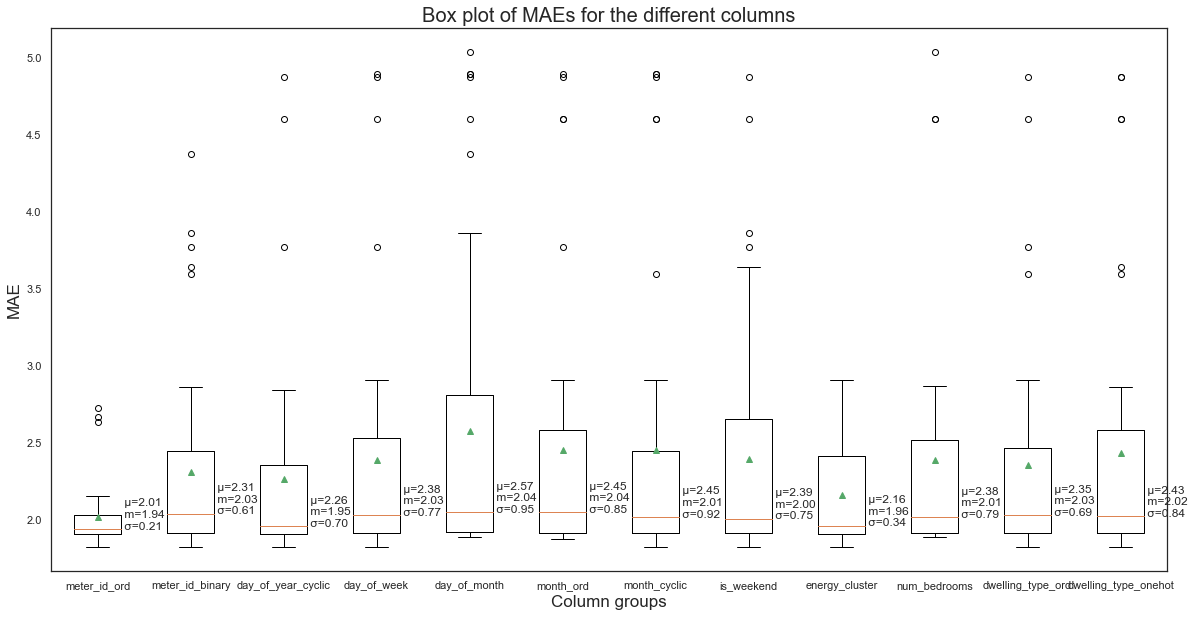

In [225]:
columns_maes = {} #dictionary of each columns maes
#iterating through each column and randomly decide whether or not to pick it
for key in tqdm(possible_columns.keys()):
    column = possible_columns[key][0] # only want to check against one column for the 'in'
    #iterating through every single models results
    for i in range(len(all_results)):
        #if this column was used by the model
        if column in all_results[i][1][0]:
            # if this column doesn't yet exist in the dict, create it
            if key not in columns_maes:
                columns_maes[key]=[]
            # adding this models mae to the dict entry for this column
            columns_maes[key].append(all_results[i][0][1])

# print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}MAEs for each model which contains columns of eaach type{color.END}")
# pprint(columns_maes)

#plotting a boxplot of these
labels, data = columns_maes.keys(), columns_maes.values()
fig = plt.figure(figsize=(20,10))

bp_dict = plt.boxplot(data,showmeans=True) # getting dictionary returned from boxplot
print(bp_dict.keys())

plt.title("Box plot of MAEs for the different columns", fontsize=20)
plt.xlabel("Column groups", fontsize=17)
plt.ylabel("MAE", fontsize=17)

#adding overlayed values to the boxplot
# m1 = data3.mean(axis=0)
# st1 = data3.std(axis=0)
means = []
medians = []
std = []

for key in columns_maes.keys():
    means.append(np.mean(columns_maes[key]))
    medians.append(np.median(columns_maes[key]))
    std.append(np.std(columns_maes[key]))

for i, line in enumerate(bp_dict['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(means[i], medians[i], std[i])
    plt.text(x, y, text, horizontalalignment='left')

plt.xticks(range(1, len(labels) + 1), labels)

plt.show()

fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\{n}_Box_MAEs.png")

plt.close()

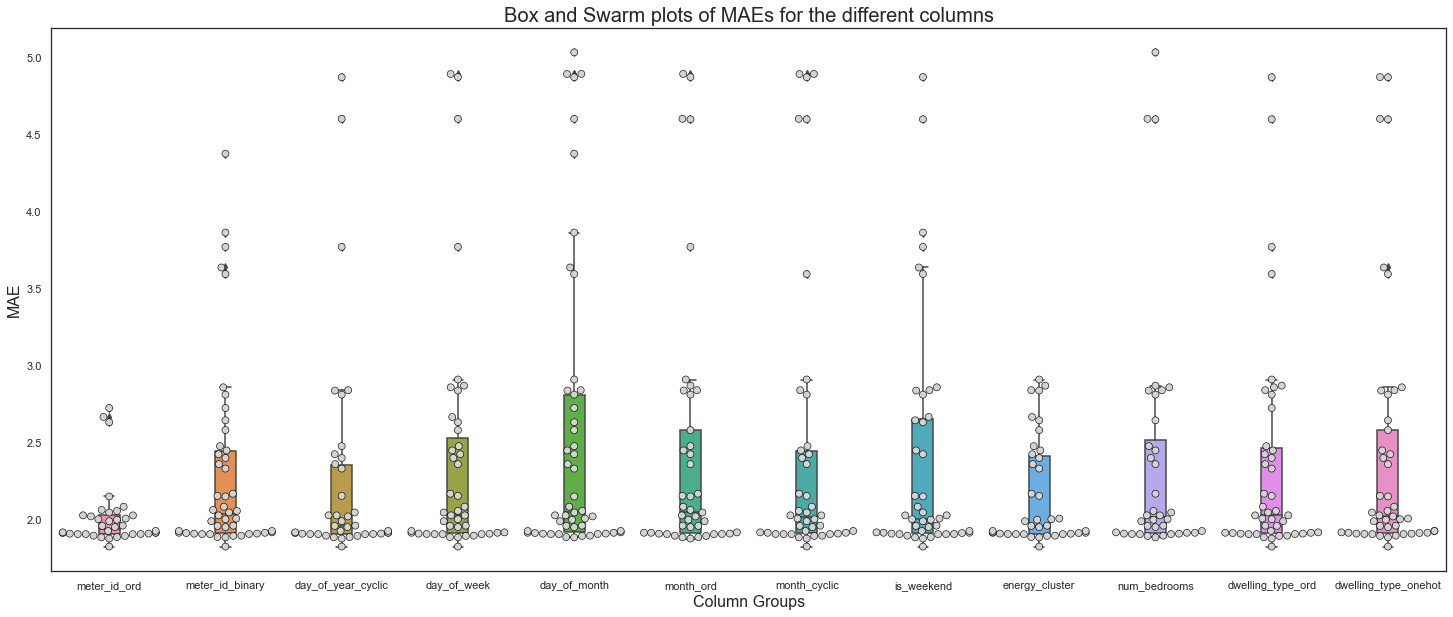

In [215]:
fig=plt.figure(figsize=(25,10))
sns.set(context='notebook', style='white')
sns.utils.axlabel(xlabel="Column Groups", ylabel="MAE", fontsize=16)
sns.swarmplot(data=list(data), size=7, edgecolor="black", linewidth=.6,color="lightgray")
sns.boxplot(data=list(data), width=.18)
plt.xticks(plt.xticks()[0], labels)

plt.title("Box and Swarm plots of MAEs for the different columns", fontsize=20)

plt.show()
fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\{n}_BoxSwarm_MAEs.png")
plt.close()

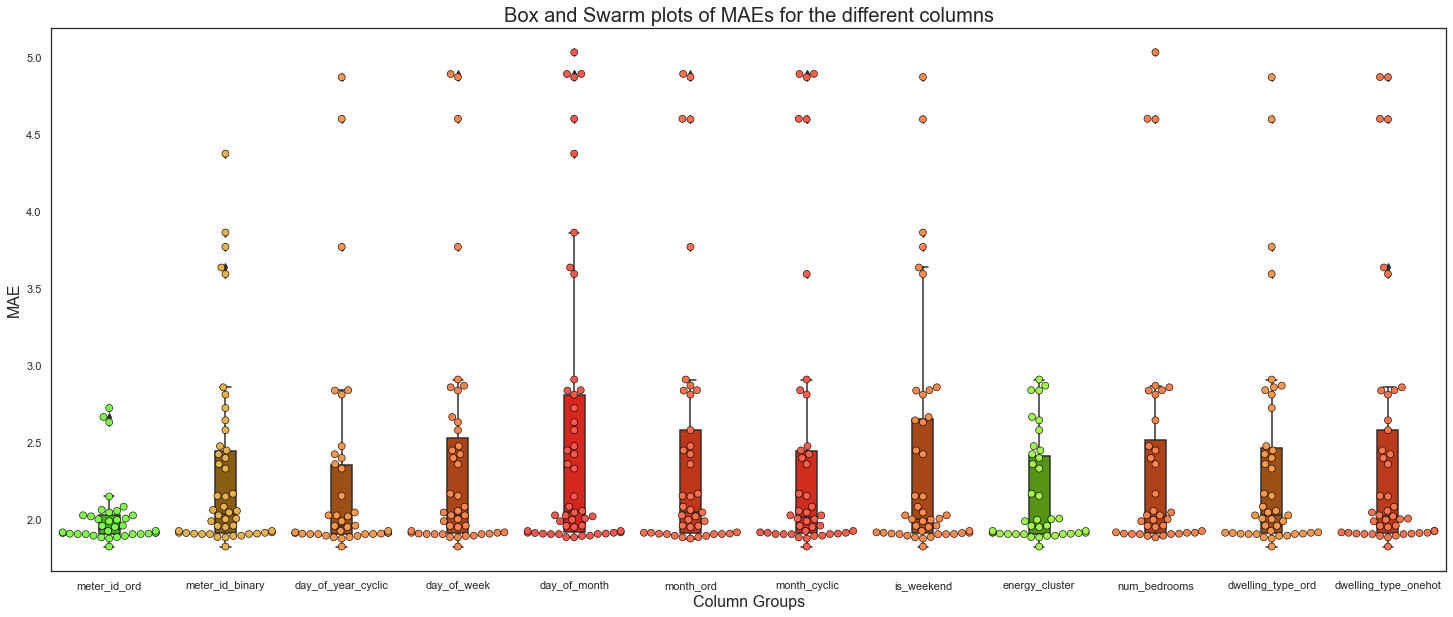

In [286]:
#gradient of green to red based on the standard deviation of the box
box_rg_std_palette = {}
for i in range(len(std)):
    box_rg_std_palette[i] = [std[i], 1-std[i],0]
    
fig=plt.figure(figsize=(25,10))
sns.set(context='notebook', style='white')
sns.utils.axlabel(xlabel="Column Groups", ylabel="MAE", fontsize=16)
sns.boxplot(data=list(data), width=.18, palette=box_rg_std_palette)

#slightly paler gradient to make it stand out from the box
swarm_rg_std_palette = box_rg_std_palette.copy()
for i in range(len(swarm_rg_std_palette)):
    #fading it to white
    swarm_rg_std_palette[i][0]+= 0.3
    if(swarm_rg_std_palette[i][0]>=1):
        swarm_rg_std_palette[i][0]=1
    swarm_rg_std_palette[i][1]+= 0.3
    if(swarm_rg_std_palette[i][1]>=1):
        swarm_rg_std_palette[i][1]=1
    swarm_rg_std_palette[i][2] += 0.3
    if(swarm_rg_std_palette[i][2]>=1):
        swarm_rg_std_palette[i][2]=1


sns.swarmplot(data=list(data), size=7, edgecolor="black", linewidth=.6, palette=swarm_rg_std_palette)

plt.xticks(plt.xticks()[0], labels)

plt.title("Box and Swarm plots of MAEs for the different columns", fontsize=20)

plt.show()
fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\{n}_BoxSwarm_MAEs_RG.png")
plt.close()

### Line chart for performance of each param

  0%|          | 0/8 [00:00<?, ?it/s]

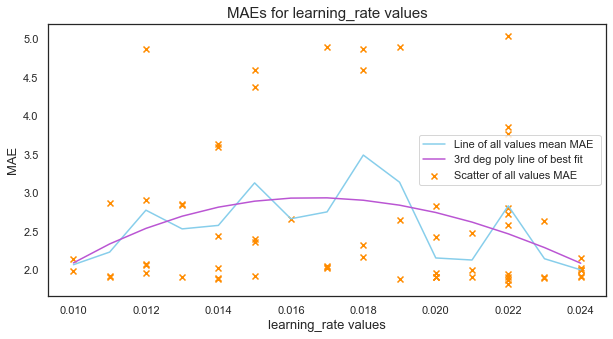

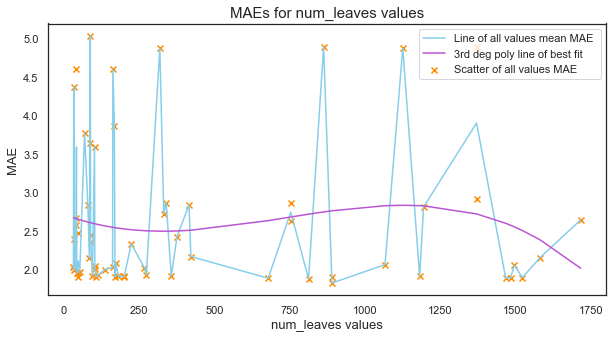

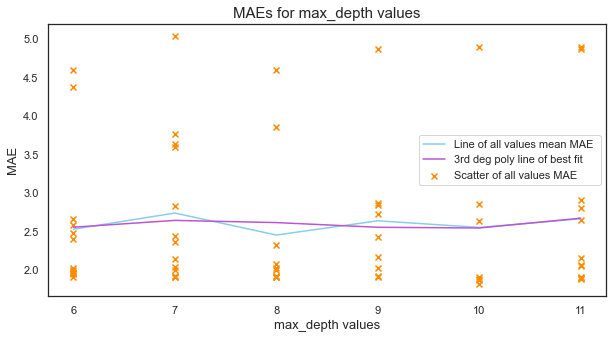

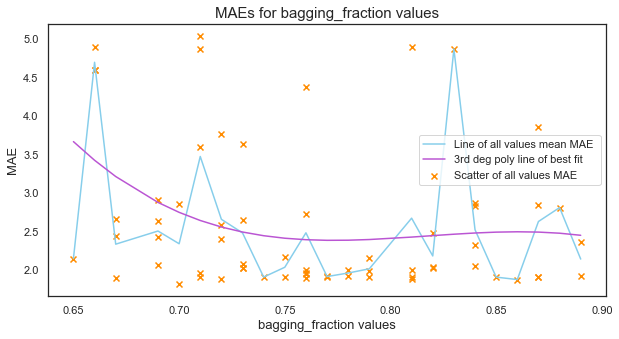

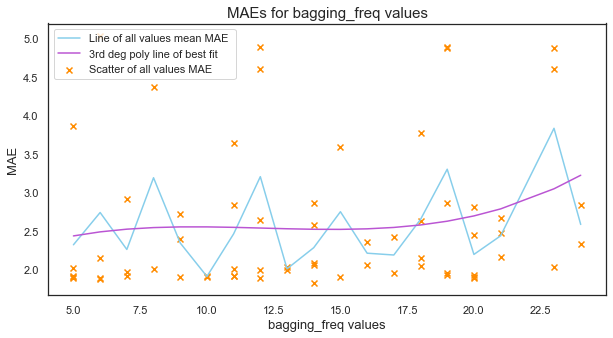

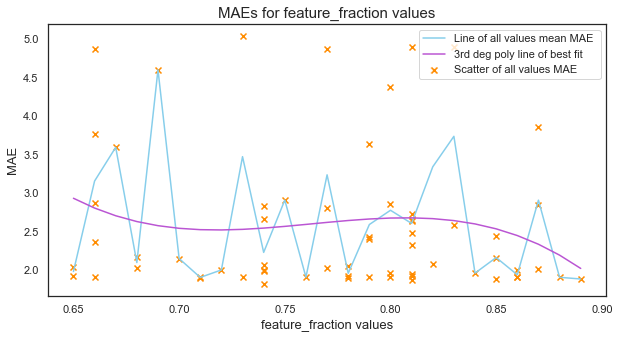

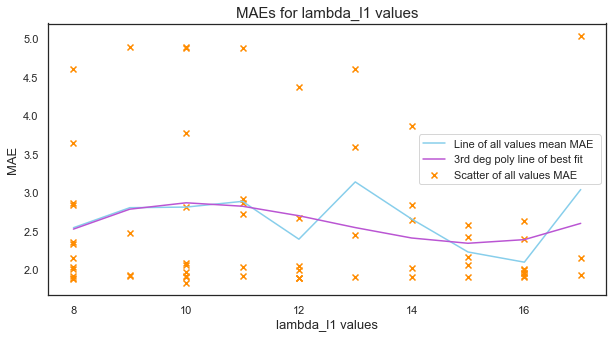

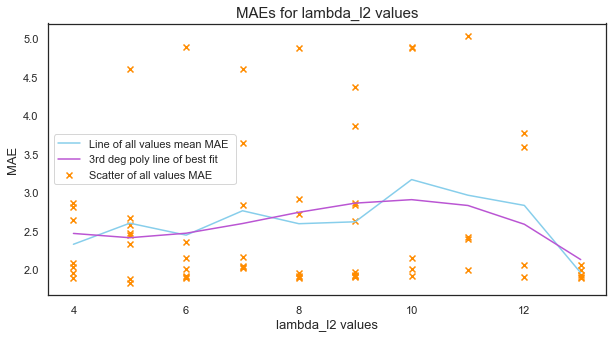

In [212]:
#array of the hyperparameters we tuned
arr_hypers = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]

#iterate through each of these hypers
for hyper in tqdm(arr_hypers):

    df_max_depth = pd.DataFrame(columns = [hyper,"MAE"])

    #iterating through each column and randomly decide whether or not to pick it
    #iterating through every single models results
    for i in range(len(all_results)):
        # adding this models mae to the dict entry for this column
        df_max_depth.loc[i] = [all_results[i][1][1][hyper],all_results[i][0][1]]

    #sort in ascending order by the params values
    df_all = df_max_depth.sort_values(by=[hyper])
    # display(df_all)

    #grouping together by value and calculating mean
    grouped_df = df_all.groupby(hyper)
    mean_df = grouped_df.mean().reset_index()
    # display(mean_df)

    #plotting the stats for this param 
    fig = plt.figure(figsize=(10,5))
    plt.plot(mean_df[hyper], mean_df.MAE, label="Line of all values mean MAE ", color="skyblue") # line of means
    plt.scatter(df_all[hyper], df_all.MAE, label="Scatter of all values MAE", color="darkorange", marker="x") # scatter of values
    plt.plot(np.unique(df_all[hyper]), 
             np.poly1d(np.polyfit(df_all[hyper], df_all.MAE, 3))
             (np.unique(df_all[hyper])), label="3rd deg poly line of best fit", color="mediumorchid") # line of best fit from a simple regressor

    plt.title(f"MAEs for {hyper} values", fontsize=15)
    plt.xlabel(f"{hyper} values", fontsize=13)
    plt.ylabel("MAE", fontsize=13)
    
    plt.legend()

    plt.show()
    fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\{n}_scatter_{hyper}.png")
    plt.close()

### inspecting stats on all models TOE and MAE

In [18]:
#inspecting the min/max/mean of time of execution of the models we tested in random search
all_toes = []
all_maes = [] 

for i in range(len(all_results)):
    #getting the results for this model
    all_toes.append(all_results[i][0][0])
    all_maes.append(all_results[i][0][1])
    
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min time of execution = {color.END}{str(datetime.timedelta(seconds=round(min(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max time of execution = {color.END}{str(datetime.timedelta(seconds=round(max(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean time of execution = {color.END}{str(datetime.timedelta(seconds=round(np.mean(all_toes))))}")
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min MAE = {color.END}{min(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max MAE= {color.END}{max(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean MAE = {color.END}{np.mean(all_maes)}")


min time of execution = 0:00:21
max time of execution = 0:42:48
mean time of execution = 0:20:10

min MAE = 1.8228017449341711
max MAE= 5.034697466308058
mean MAE = 2.6033680678376854


## Inspecting the results of the hyper parameter optimization

In [19]:
best_index = 0
best_mae = 999999

for i in range(len(all_results)):
    #getting the results for this model
    LGBM_TOE = all_results[i][0][0]
    LGBM_MAE = all_results[i][0][1]
    #displaying the results
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}skf-cv run {i}{color.END}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:{color.END} {str(datetime.timedelta(seconds=round(LGBM_TOE)))}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}")
    print("")
    
    #keeping track of the best performing model
    if(LGBM_MAE<best_mae):
        best_mae=LGBM_MAE
        best_index = i
print("best model is at index",best_index,"with a MAE of",best_mae)

skf-cv run 0
Time of execution for skf-cv: 0:10:03
Mean absolute error between OOF preds and meter_reading on training set: 2.6305426146690354

skf-cv run 1
Time of execution for skf-cv: 0:25:36
Mean absolute error between OOF preds and meter_reading on training set: 3.863540400362186

skf-cv run 2
Time of execution for skf-cv: 0:00:31
Mean absolute error between OOF preds and meter_reading on training set: 4.894687320462318

skf-cv run 3
Time of execution for skf-cv: 0:23:13
Mean absolute error between OOF preds and meter_reading on training set: 1.8826133668181857

skf-cv run 4
Time of execution for skf-cv: 0:13:19
Mean absolute error between OOF preds and meter_reading on training set: 2.0046307583701717

skf-cv run 5
Time of execution for skf-cv: 0:00:38
Mean absolute error between OOF preds and meter_reading on training set: 4.874160443381934

skf-cv run 6
Time of execution for skf-cv: 0:12:45
Mean absolute error between OOF preds and meter_reading on training set: 4.3761981406819

## Making predictions on best model

In [20]:
#making predictions based on the best performing model and displaying it's information
BEST_LGBM_MODELS = all_results[best_index][0][2] #getting the lgbm_models from the best index
BEST_LGBM_FORECASTS = df_preds.copy()
start_time = time.time() 

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(BEST_LGBM_MODELS)):
    pred_forecasts = BEST_LGBM_MODELS[i].predict(BEST_LGBM_FORECASTS[all_results[best_index][1][0]], num_iteration=BEST_LGBM_MODELS[i].best_iteration_) #predicting the unkown df_preds
    BEST_LGBM_FORECASTS[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
BEST_LGBM_FORECASTS["meter_reading"] = BEST_LGBM_FORECASTS.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0
execution_time = time.time() - start_time

## Inspecting information on best model

In [21]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}best model came from skf-cv run {best_index}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(all_results[best_index][0][0])))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for predictions: {color.END}{str(datetime.timedelta(seconds=round(execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Total time of execution: {color.END}{str(datetime.timedelta(seconds=round(all_results[best_index][0][0]+execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {all_results[best_index][0][1]}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}preds set with the next years forecasts for each meter{color.END}")
display(BEST_LGBM_FORECASTS[["meter_id","date","meter_reading"]])
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(all_results[best_index][1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(all_results[best_index][1][1])

best model came from skf-cv run 30
Evaluation and results
Time of execution for skf-cv:  0:31:22

Time of execution for predictions: 1:08:19

Total time of execution: 1:39:41

Mean absolute error between OOF preds and meter_reading on training set: 1.8228017449341711

preds set with the next years forecasts for each meter


,meter_id,date,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-01,5.908430
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-02,6.045385
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-03,6.017474
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-04,5.797958
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-05,5.746486
...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-27,22.032141
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-28,21.766075
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-29,21.412747
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-30,19.799684


Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'dwelling_type_ord',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.7,
 'bagging_freq': 14,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.74,
 'lambda_l1': 10,
 'lambda_l2': 5,
 'learning_rate': 0.022,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 891,
 'num_threads': -1,
 'seed': 137}


## Saving the description of the best model

In [22]:
BEST_LGBM_FORECASTS.to_pickle(f"..\\Results\\Unclustered Random Search\\{n}_best_model_daily_forecasts.pkl")

In [23]:
import pickle

a = {'hello': 'world'}
desc_disc = {
    "time_of_execution_skf-cv":str(datetime.timedelta(seconds=round(all_results[best_index][0][0]))),
    "time_of_execution_preds":str(datetime.timedelta(seconds=round(execution_time))),
    "time_of_execution_total":str(datetime.timedelta(seconds=round(all_results[best_index][0][0]+execution_time))),
    "MAE":all_results[best_index][0][1],
    "features":all_results[best_index][1][0],
    "params":all_results[best_index][1][1]
}

with open(f"..\\Results\\Unclustered Random Search\\{n}_best_model_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Unclustered Random Search\\{n}_best_model_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

{'MAE': 1.8228017449341711,
 'features': ['meter_id_ord',
              'meter_id_0',
              'meter_id_1',
              'meter_id_2',
              'meter_id_3',
              'meter_id_4',
              'meter_id_5',
              'meter_id_6',
              'meter_id_7',
              'meter_id_8',
              'meter_id_9',
              'meter_id_10',
              'meter_id_11',
              'meter_id_12',
              'day_of_year_sin',
              'day_of_year_cos',
              'day_of_week',
              'month_sin',
              'month_cos',
              'is_weekend',
              'energy_cluster',
              'dwelling_type_ord',
              'detached',
              'flat',
              'semi_detached',
              'terraced'],
 'params': {'bagging_fraction': 0.7,
            'bagging_freq': 14,
            'boosting_type': 'gbdt',
            'feature_fraction': 0.74,
            'lambda_l1': 10,
            'lambda_l2': 5,
            'learning_ra

# Converting into monthly forecasts

In [24]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

,meter_id,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,131.808698,121.396210,128.257528,115.428110,111.354130,113.053250,115.105787,111.743499,107.652719,115.669088,114.221236,130.676862
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,709.136139,644.437945,500.864445,434.544314,438.995673,410.107444,375.627310,380.522033,457.876411,526.348855,602.637112,646.451518
2,0x0019979ee12c59accd24d1c83291528ced1bb734,232.298731,184.637004,206.059285,175.459345,150.631613,156.468046,164.671505,180.212740,177.306953,195.947743,206.511487,253.862201
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,153.685179,144.359732,148.195153,137.419261,133.726656,137.453120,135.549490,136.467479,131.922635,138.973242,147.937132,153.881780
4,0x005958406351bb29580475df698b5f1070096397,307.730088,266.011446,263.919528,221.725382,223.740442,223.324133,230.333360,226.742761,217.026334,255.371713,285.083752,326.806079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,213.983338,167.998693,166.167125,153.188325,146.940135,137.503603,138.072070,140.690869,135.768293,145.108990,150.575305,170.159430
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,681.472015,639.071247,712.915913,651.504860,587.697342,474.804173,475.424979,491.388074,529.777275,558.247930,573.184386,611.772160
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,455.145674,405.067084,414.849249,361.730316,336.245313,279.959771,275.618048,283.187920,292.775509,349.276592,417.833633,502.321833
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,369.521144,344.591828,334.162696,336.900352,230.844617,211.958815,214.817611,225.396862,233.204468,268.330454,299.642969,358.259897


## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [25]:
df_monthly_forecasts.to_csv(f"..\\Results\\Unclustered Random Search\\{n}_best_model_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [26]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

,meter_id,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,131.808698,121.396210,128.257528,115.428110,111.354130,113.053250,115.105787,111.743499,107.652719,115.669088,114.221236,130.676862
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,709.136139,644.437945,500.864445,434.544314,438.995673,410.107444,375.627310,380.522033,457.876411,526.348855,602.637112,646.451518
2,0x0019979ee12c59accd24d1c83291528ced1bb734,232.298731,184.637004,206.059285,175.459345,150.631613,156.468046,164.671505,180.212740,177.306953,195.947743,206.511487,253.862201
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,153.685179,144.359732,148.195153,137.419261,133.726656,137.453120,135.549490,136.467479,131.922635,138.973242,147.937132,153.881780
4,0x005958406351bb29580475df698b5f1070096397,307.730088,266.011446,263.919528,221.725382,223.740442,223.324133,230.333360,226.742761,217.026334,255.371713,285.083752,326.806079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,213.983338,167.998693,166.167125,153.188325,146.940135,137.503603,138.072070,140.690869,135.768293,145.108990,150.575305,170.159430
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,681.472015,639.071247,712.915913,651.504860,587.697342,474.804173,475.424979,491.388074,529.777275,558.247930,573.184386,611.772160
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,455.145674,405.067084,414.849249,361.730316,336.245313,279.959771,275.618048,283.187920,292.775509,349.276592,417.833633,502.321833
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,369.521144,344.591828,334.162696,336.900352,230.844617,211.958815,214.817611,225.396862,233.204468,268.330454,299.642969,358.259897


## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [27]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

,meter_id,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-06 00:00:00,2018-01-07 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,...,2018-12-22 00:00:00,2018-12-23 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-29 00:00:00,2018-12-30 00:00:00,2018-12-31 00:00:00
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,4.480916,4.286247,4.203990,4.249888,4.193906,4.323003,4.709673,4.625745,4.397453,...,4.318876,4.268079,3.825601,3.564231,3.656332,3.847382,4.102676,4.254943,4.181128,4.062687
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,19.018961,19.121294,19.551450,19.294325,20.164790,20.645397,22.381986,22.451261,22.579051,...,22.767096,23.197559,21.491069,19.739154,18.880469,19.399914,20.992403,19.448494,18.763620,17.488171
2,0x0019979ee12c59accd24d1c83291528ced1bb734,8.566852,8.803544,8.281589,8.531709,8.224801,7.846470,7.693852,7.574412,7.617361,...,8.436079,8.389688,7.815321,8.339787,8.425028,9.038199,9.100798,9.221641,8.925110,8.880214
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,5.074986,5.151389,5.028161,5.311182,5.031993,5.080667,5.123186,4.683912,4.768825,...,4.763129,4.920076,4.423786,4.634076,4.574327,5.002644,5.021696,5.286944,5.462033,5.029301
4,0x005958406351bb29580475df698b5f1070096397,11.320216,10.439876,10.480641,10.752945,10.992747,10.639861,10.338727,11.088660,10.074550,...,11.287474,11.398923,11.805713,10.861631,10.552239,11.244083,11.452830,11.261674,10.690513,11.244282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,6.311530,6.359557,6.070000,6.495397,6.620729,6.684744,6.790205,7.336642,7.265167,...,5.913620,5.726738,5.413929,5.270705,5.110711,5.025099,5.167100,5.473965,5.714816,5.697943
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,19.934999,20.363442,20.511303,20.385298,20.322896,19.881169,20.024949,21.192954,21.814343,...,18.541447,18.471120,17.994709,17.813252,17.765906,19.382276,20.003110,19.004008,18.333339,19.082466
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,15.816327,14.529676,14.642932,14.376745,14.515421,14.376202,14.377915,14.646814,13.964095,...,14.866271,15.610492,16.260992,14.766224,14.085903,14.966131,15.098011,15.214153,15.336794,15.731831
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,12.519127,12.132736,12.174425,12.046672,12.052097,12.199873,12.075629,12.224331,11.487745,...,11.937346,11.913156,12.265862,11.957765,11.821684,12.359045,12.406064,12.315281,11.665931,12.375147


## loading training data and aggregating into months

In [28]:
#loading the training data
print("training data")
df_train = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train[columns].sum(axis=1)

df_train_monthly

training data


  0%|          | 0/12 [00:00<?, ?it/s]

,meter_id,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,128.39450
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,553.18400
2,0x0019979ee12c59accd24d1c83291528ced1bb734,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,368.90957
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,534.84650
4,0x005958406351bb29580475df698b5f1070096397,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,946.06400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,72.7050,63.245,68.4335,66.6265,69.0480,100.430,177.1735,177.4100,216.7245,279.164500,351.481000,312.08800
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,371.4390,269.691,179.3430,141.6590,138.4835,122.910,164.2285,100.9610,118.0520,123.135500,187.140000,186.88400
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,209.8065,169.858,184.0130,166.7280,134.1760,169.489,157.5775,165.9640,177.0105,185.701833,192.288667,200.61950
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,845.6630,608.449,588.7765,503.3050,291.1320,177.605,183.5345,182.0350,244.2255,371.458333,695.878667,858.83950


## Plotting the predictions against the training data

In [224]:
for pid in tqdm(range(0,3248)):
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_train_day = df_train.loc[df_train['meter_id'] == meter_id].T[1:]
    this_preds_day = df_daily_forecasts.loc[df_daily_forecasts['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    this_train_day.index=pd.to_datetime(this_train_day.index)
    this_preds_day.index=pd.to_datetime(this_preds_day.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,20))
    
    #plotting the monthly predictions
    plt.subplot(2,1,1)
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    
    #plotting the daily predictions
    plt.subplot(2,1,2)
    plt.title("Meter '"+str(meter_id)+"' daily forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_day, label="training daily energy", lw=1,color="skyblue")
    plt.plot(this_preds_day, label="forecast daily energy", lw=1,color="mediumorchid")

    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    #plt.show()

    fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\forecasts\\{n}_forecasts_{pid}_{meter_id}.png")

    plt.close()

  0%|          | 0/3248 [00:00<?, ?it/s]